In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          13029         410        2049         247       10569       12122
Swap:             0           0           0


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!ls ./drive/datasets/dog_cat

dog_cat_model1.h5	   np_arrays_test_y.npy   numpy_arrays_x
dog_cat_model.h5	   np_arrays_train_y.npy  numpy_arrays_y
dog_cat_model_weights1.h5  np_array_test_x.npy	  train_images.zip
dog_cat_model_weights.h5   np_array_train_x.npy


***Code Starts here***

In [0]:
#importing dependecies to create dataset
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import random
import numpy as np


In [0]:
#function takes a file name and returns output label in the form of one hot vector
#[0,1]=dog [1,0]=cat
def output_label(l):
    lb=l.split('.')[0]
    #print(ar)
    if str(lb)==str('cat'):
        return [1,0]
    else:
        return [0,1]

In [0]:
#function below loads an image, resizes it and returns corresponding numpy array
def load_image(path,width):
    img=Image.open(path)
    img = img.resize((width,width))  
    a=np.array(img)
    return a

***Extracting images from zip and resizing them***

In [0]:
x=[]
y=[]
l=[]
filename = './drive/datasets/dog_cat/train_images.zip'
with ZipFile(filename) as archive:
    l=archive.namelist()
    entries=archive.infolist()
    for i in range(len(entries)):
        with archive.open(entries[i]) as file:
            x.append(load_image(file,128))
            y.append(output_label(l[i]))
                  
        if (i+1)%1000==0:
          print('images processed so far',i+1)

images processed so far 1000
images processed so far 2000
images processed so far 3000
images processed so far 4000
images processed so far 5000
images processed so far 6000
images processed so far 7000
images processed so far 8000
images processed so far 9000
images processed so far 10000
images processed so far 11000
images processed so far 12000
images processed so far 13000
images processed so far 14000
images processed so far 15000
images processed so far 16000
images processed so far 17000
images processed so far 18000
images processed so far 19000
images processed so far 20000
images processed so far 21000
images processed so far 22000
images processed so far 23000
images processed so far 24000
images processed so far 25000


In [0]:
# spliting into training and testing data
from sklearn.model_selection import train_test_split
train_data,test_data,train_label,test_label=train_test_split(x,y,test_size=0.2,random_state=16)

In [0]:
# converting them into numpy array
train_x=np.array(train_data)
train_y=np.array(train_label)

test_x=np.array(test_data)
test_y=np.array(test_label)



In [0]:
# printing shapes of traing and testing data
print(train_x.shape)
print(train_y.shape)

print(test_x.shape)
print(test_y.shape)

20000
(20000, 2)
(5000, 128, 128, 3)
(5000, 2)


In [0]:
del x
del y
del train_data
del test_data
del train_label
del test_label

**Save the numpy array, to reduce the computation needed for extracting and preprocessing**

In [0]:
np.save('./drive/datasets/dog_cat/np_array_train_x.npy',train_x)
np.save('./drive/datasets/dog_cat/np_arrays_train_y.npy',train_y)

np.save('./drive/datasets/dog_cat/np_array_test_x.npy',test_x)
np.save('./drive/datasets/dog_cat/np_arrays_test_y.npy',test_y)

In [0]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          13029         450        7683         247        4895       12095
Swap:             0           0           0


In [0]:
!ls ./drive/datasets/dog_cat

np_arrays_test_y.npy   np_array_test_x.npy   numpy_arrays_x  train_images.zip
np_arrays_train_y.npy  np_array_train_x.npy  numpy_arrays_y


***Now Numpy array can be loaded from disk and used***

In [0]:
# Loading all the corresponding numpy array

train_x = np.load('./drive/datasets/dog_cat/np_array_train_x.npy')
train_y = np.load('./drive/datasets/dog_cat/np_arrays_train_y.npy')

test_x = np.load('./drive/datasets/dog_cat/np_array_test_x.npy')
test_y = np.load('./drive/datasets/dog_cat/np_arrays_test_y.npy')

In [10]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          13029        1647         245         247       11136       10885
Swap:             0           0           0


***Creating the Model***

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
__________

In [0]:
# Define the optimizer
from keras.optimizers import RMSprop
from keras.optimizers import Adam,SGD
optimizer = SGD(lr=0.01, momentum=0.9,nesterov=True)
#optimizer = RMSprop(lr=0.01)

In [0]:
# Set a learning rate annealer
#this is to reduce the learning rate after some patience with some factor till min_lr

from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

**Loss = "categorical_crossentropy" for classification and optimizer is SGD**

In [0]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
epochs = 20
batch_size = 100

nb_train_samples=int(train_x.shape[0])
nb_validation_samples=int(test_x.shape[0])

steps_per_epoch=nb_train_samples // batch_size
validation_steps=nb_validation_samples // batch_size

In [14]:
print(nb_train_samples)
print(nb_validation_samples)
print(steps_per_epoch)
print(validation_steps)

20000
5000
200
50


**Using Keras ImageDataGenerator for image augmentation**

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


Use of  ***fit_generator***  and ***predict_genrator*** with custom data generator functions which can load images to memory duuring training and prediction.

There is ***ImageDataGenerator()***  in Keras which provides one such generator, which we can create using ***flow()*** or ***flow_from_directory***

[>>flow and flow from directory](https://towardsdatascience.com/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2)

In [0]:
train_generator = train_datagen.flow(train_x, train_y, batch_size=batch_size)
validation_generator = val_datagen.flow(test_x, test_y, batch_size=batch_size)

In [17]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          13029        7160         164         378        5704        5242
Swap:             0           0           0


In [20]:
# Fit the model
history=model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[learning_rate_reduction]
)

Epoch 1/20
200/200 [==============================] - 129s 647ms/step - loss: 0.6838 - acc: 0.5595 - val_loss: 0.6670 - val_acc: 0.5876
Epoch 2/20
200/200 [==============================] - 123s 615ms/step - loss: 0.6380 - acc: 0.6408 - val_loss: 0.6291 - val_acc: 0.6526
Epoch 3/20
 98/200 [=============>................] - ETA: 48s - loss: 0.6079 - acc: 0.6707

200/200 [==============================] - 123s 617ms/step - loss: 0.5977 - acc: 0.6784 - val_loss: 0.5538 - val_acc: 0.7142
Epoch 4/20
200/200 [==============================] - 123s 616ms/step - loss: 0.5575 - acc: 0.7078 - val_loss: 0.5152 - val_acc: 0.7466
Epoch 5/20
136/200 [===================>..........] - ETA: 31s - loss: 0.5377 - acc: 0.7261

200/200 [==============================] - 124s 619ms/step - loss: 0.5305 - acc: 0.7328 - val_loss: 0.4964 - val_acc: 0.7674
Epoch 6/20
200/200 [==============================] - 123s 617ms/step - loss: 0.5025 - acc: 0.7512 - val_loss: 0.4846 - val_acc: 0.7622
Epoch 7/20
145/200 [====================>.........] - ETA: 26s - loss: 0.4808 - acc: 0.7648

200/200 [==============================] - 123s 616ms/step - loss: 0.4818 - acc: 0.7665 - val_loss: 0.4665 - val_acc: 0.7856
Epoch 8/20
200/200 [==============================] - 123s 616ms/step - loss: 0.4610 - acc: 0.7804 - val_loss: 0.4355 - val_acc: 0.8008
Epoch 9/20
147/200 [=====================>........] - ETA: 25s - loss: 0.4435 - acc: 0.7912

200/200 [==============================] - 123s 617ms/step - loss: 0.4424 - acc: 0.7923 - val_loss: 0.4487 - val_acc: 0.7878
Epoch 10/20
200/200 [==============================] - 123s 617ms/step - loss: 0.4242 - acc: 0.8047 - val_loss: 0.4653 - val_acc: 0.7700
Epoch 11/20
146/200 [====================>.........] - ETA: 26s - loss: 0.4127 - acc: 0.8119

200/200 [==============================] - 123s 616ms/step - loss: 0.4116 - acc: 0.8123 - val_loss: 0.3970 - val_acc: 0.8222
Epoch 12/20
200/200 [==============================] - 124s 618ms/step - loss: 0.3930 - acc: 0.8238 - val_loss: 0.3835 - val_acc: 0.8256
Epoch 13/20
145/200 [====================>.........] - ETA: 26s - loss: 0.3779 - acc: 0.8303

200/200 [==============================] - 123s 617ms/step - loss: 0.3793 - acc: 0.8286 - val_loss: 0.3744 - val_acc: 0.8344
Epoch 14/20
200/200 [==============================] - 123s 615ms/step - loss: 0.3571 - acc: 0.8429 - val_loss: 0.3558 - val_acc: 0.8438
Epoch 15/20
145/200 [====================>.........] - ETA: 26s - loss: 0.3534 - acc: 0.8475

200/200 [==============================] - 123s 615ms/step - loss: 0.3542 - acc: 0.8461 - val_loss: 0.3415 - val_acc: 0.8496
Epoch 16/20
200/200 [==============================] - 123s 614ms/step - loss: 0.3393 - acc: 0.8526 - val_loss: 0.3274 - val_acc: 0.8554
Epoch 17/20
145/200 [====================>.........] - ETA: 26s - loss: 0.3302 - acc: 0.8568

200/200 [==============================] - 123s 616ms/step - loss: 0.3321 - acc: 0.8553 - val_loss: 0.3266 - val_acc: 0.8574
Epoch 18/20
200/200 [==============================] - 123s 616ms/step - loss: 0.3148 - acc: 0.8627 - val_loss: 0.3238 - val_acc: 0.8572
Epoch 19/20
145/200 [====================>.........] - ETA: 26s - loss: 0.3004 - acc: 0.8682

200/200 [==============================] - 123s 616ms/step - loss: 0.3005 - acc: 0.8696 - val_loss: 0.3308 - val_acc: 0.8522
Epoch 20/20
200/200 [==============================] - 123s 617ms/step - loss: 0.2926 - acc: 0.8741 - val_loss: 0.3288 - val_acc: 0.8586


**Plotting the graphs**

Go to [Display-deep-learning-model](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/) for more details.


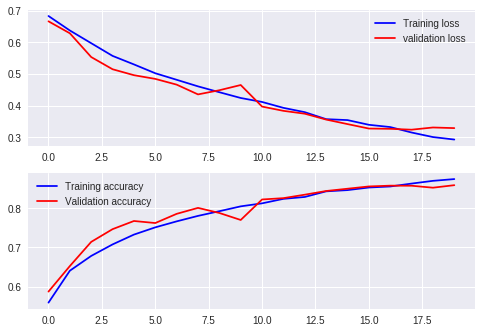

In [21]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
model.evaluate_generator(train_generator,steps_per_epoch)

[0.26043617323040963, 0.8901500016450882]

In [23]:
model.evaluate_generator(validation_generator,validation_steps)

[0.3271132600307465, 0.8552000057697297]

In [41]:
model.evaluate(test_x,test_y)

5000/5000 [==============================] - 7s 1ms/step


[4.097232284545899, 0.739]

In [40]:
final_loss, final_acc = model.evaluate(test_x, test_y, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 4.0972, final accuracy: 0.7390


In [0]:
model.save_weights("./drive/datasets/dog_cat/dog_cat_model_weights.h5")
model.save('./drive/datasets/dog_cat/dog_cat_model.h5')

**Loading the model which was saved earlier**

In [1]:
! free -m

              total        used        free      shared  buff/cache   available
Mem:          13029         438        7463         247        5126       12094
Swap:             0           0           0


In [2]:
from keras.models import load_model
new_model = load_model('./drive/datasets/dog_cat/dog_cat_model.h5')

Using TensorFlow backend.


In [0]:
#new_model.summary()

In [0]:
#new_model.get_weights()

**You can train this model further  by assigning it to your own weights saved earlier, next we'll see how we can use the weights of predefined models like vgg16, this is called transfer learning.**

In [20]:
# Calling fit_genrator on new_model
history=new_model.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[learning_rate_reduction]
)

Epoch 1/20
200/200 [==============================] - 128s 640ms/step - loss: 0.2854 - acc: 0.8757 - val_loss: 0.3095 - val_acc: 0.8730
Epoch 2/20
200/200 [==============================] - 123s 613ms/step - loss: 0.2718 - acc: 0.8856 - val_loss: 0.3100 - val_acc: 0.8670
Epoch 3/20
 98/200 [=============>................] - ETA: 47s - loss: 0.2682 - acc: 0.8868

200/200 [==============================] - 123s 615ms/step - loss: 0.2659 - acc: 0.8885 - val_loss: 0.2989 - val_acc: 0.8720
Epoch 4/20
200/200 [==============================] - 123s 615ms/step - loss: 0.2588 - acc: 0.8940 - val_loss: 0.3025 - val_acc: 0.8772
Epoch 5/20
136/200 [===================>..........] - ETA: 30s - loss: 0.2494 - acc: 0.8962

200/200 [==============================] - 123s 614ms/step - loss: 0.2520 - acc: 0.8958 - val_loss: 0.2951 - val_acc: 0.8756
Epoch 6/20
200/200 [==============================] - 122s 611ms/step - loss: 0.2382 - acc: 0.9005 - val_loss: 0.2814 - val_acc: 0.8798
Epoch 7/20
145/200 [====================>.........] - ETA: 26s - loss: 0.2325 - acc: 0.9069

200/200 [==============================] - 121s 607ms/step - loss: 0.2336 - acc: 0.9058 - val_loss: 0.2954 - val_acc: 0.8768
Epoch 8/20
200/200 [==============================] - 122s 612ms/step - loss: 0.2278 - acc: 0.9049 - val_loss: 0.2794 - val_acc: 0.8858
Epoch 9/20
147/200 [=====================>........] - ETA: 25s - loss: 0.2213 - acc: 0.9084

200/200 [==============================] - 123s 615ms/step - loss: 0.2265 - acc: 0.9063 - val_loss: 0.2855 - val_acc: 0.8806
Epoch 10/20
200/200 [==============================] - 122s 612ms/step - loss: 0.2115 - acc: 0.9131 - val_loss: 0.2915 - val_acc: 0.8772
Epoch 11/20
146/200 [====================>.........] - ETA: 25s - loss: 0.1980 - acc: 0.9177

200/200 [==============================] - 122s 612ms/step - loss: 0.2028 - acc: 0.9158 - val_loss: 0.3029 - val_acc: 0.8740

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 12/20
200/200 [==============================] - 122s 612ms/step - loss: 0.1778 - acc: 0.9280 - val_loss: 0.2687 - val_acc: 0.8908
Epoch 13/20
 81/200 [===========>..................] - ETA: 54s - loss: 0.1694 - acc: 0.9337

200/200 [==============================] - 121s 607ms/step - loss: 0.1647 - acc: 0.9344 - val_loss: 0.2748 - val_acc: 0.8958
Epoch 14/20
200/200 [==============================] - 122s 611ms/step - loss: 0.1582 - acc: 0.9371 - val_loss: 0.2658 - val_acc: 0.8964
Epoch 15/20
131/200 [==================>...........] - ETA: 32s - loss: 0.1531 - acc: 0.9389

200/200 [==============================] - 122s 612ms/step - loss: 0.1518 - acc: 0.9400 - val_loss: 0.2881 - val_acc: 0.8886
Epoch 16/20
200/200 [==============================] - 122s 612ms/step - loss: 0.1462 - acc: 0.9435 - val_loss: 0.2808 - val_acc: 0.8962
Epoch 17/20
142/200 [====================>.........] - ETA: 27s - loss: 0.1407 - acc: 0.9426

200/200 [==============================] - 123s 613ms/step - loss: 0.1420 - acc: 0.9430 - val_loss: 0.2811 - val_acc: 0.8908

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
Epoch 18/20
200/200 [==============================] - 122s 611ms/step - loss: 0.1358 - acc: 0.9470 - val_loss: 0.2716 - val_acc: 0.8996
Epoch 19/20
 80/200 [===========>..................] - ETA: 54s - loss: 0.1342 - acc: 0.9450

200/200 [==============================] - 122s 611ms/step - loss: 0.1327 - acc: 0.9463 - val_loss: 0.2729 - val_acc: 0.8960
Epoch 20/20
200/200 [==============================] - 122s 609ms/step - loss: 0.1286 - acc: 0.9489 - val_loss: 0.2578 - val_acc: 0.9034


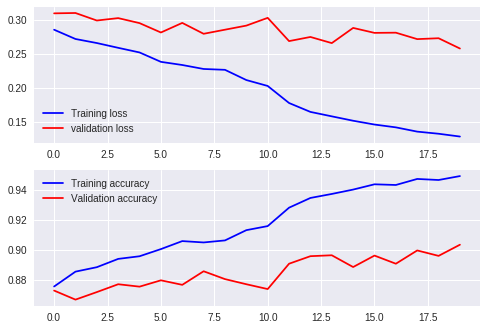

In [21]:
# Plot the loss and accuracy curves for training and validation on new_model
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [22]:
new_model.evaluate_generator(train_generator,steps_per_epoch)

[0.08561907796189189, 0.969950007200241]

In [23]:
new_model.evaluate_generator(validation_generator,validation_steps)

[0.2698046077787876, 0.8967999994754792]

In [26]:
new_model.evaluate(test_x,test_y)

5000/5000 [==============================] - 7s 1ms/step


[3.6981506912231445, 0.767]

In [0]:
# saving the new weights and model.
new_model.save_weights("./drive/datasets/dog_cat/dog_cat_model_weights1.h5")
new_model.save('./drive/datasets/dog_cat/dog_cat_model1.h5')

**Transfer Learning using ** *** Keras  "Applications"*** 

[>> VGG16 Keras](https://keras.io/applications/#vgg16)

In [0]:
from keras import applications

img_width=128
img_height=128

model_vgg16 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [37]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
"""
for layer in model_vgg16.layers[:5]:
    layer.trainable = False
"""

'\nfor layer in model_vgg16.layers[:5]:\n    layer.trainable = False\n'

In [0]:
#Adding custom Layers 
x = model_vgg16.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [39]:
# creating the final model

from keras.models import Sequential, Model
model_final = Model(input = model_vgg16.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# Define the optimizer
from keras.optimizers import RMSprop
from keras.optimizers import Adam,SGD
optimizer = SGD(lr=0.001, momentum=0.9,nesterov=True)
#optimizer = RMSprop(lr=0.01)

In [0]:
# Set a learning rate annealer
#this is to reduce the learning rate after some patience with some factor till min_lr

from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

In [0]:
epochs = 10
batch_size = 100

nb_train_samples=int(train_x.shape[0])
nb_validation_samples=int(test_x.shape[0])

steps_per_epoch=nb_train_samples // batch_size
validation_steps=nb_validation_samples // batch_size

In [47]:
print(nb_train_samples)
print(nb_validation_samples)
print(steps_per_epoch)
print(validation_steps)

20000
5000
200
50


In [0]:
# Compile the model
model_final.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [50]:
# Fit the model
history=model_final.fit_generator(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[learning_rate_reduction]
)

Epoch 1/10
200/200 [==============================] - 240s 1s/step - loss: 0.0836 - acc: 0.9681 - val_loss: 0.0917 - val_acc: 0.9632
Epoch 2/10
200/200 [==============================] - 239s 1s/step - loss: 0.0621 - acc: 0.9752 - val_loss: 0.0856 - val_acc: 0.9682
Epoch 3/10
101/200 [==============>...............] - ETA: 1:44 - loss: 0.0560 - acc: 0.9785

200/200 [==============================] - 240s 1s/step - loss: 0.0548 - acc: 0.9790 - val_loss: 0.0873 - val_acc: 0.9674
Epoch 4/10
200/200 [==============================] - 240s 1s/step - loss: 0.0483 - acc: 0.9821 - val_loss: 0.0833 - val_acc: 0.9698
Epoch 5/10
140/200 [====================>.........] - ETA: 1:03 - loss: 0.0426 - acc: 0.9820

200/200 [==============================] - 240s 1s/step - loss: 0.0440 - acc: 0.9826 - val_loss: 0.0866 - val_acc: 0.9692
Epoch 6/10
200/200 [==============================] - 239s 1s/step - loss: 0.0347 - acc: 0.9863 - val_loss: 0.0928 - val_acc: 0.9692
Epoch 7/10
149/200 [=====================>........] - ETA: 53s - loss: 0.0304 - acc: 0.9884

200/200 [==============================] - 239s 1s/step - loss: 0.0310 - acc: 0.9879 - val_loss: 0.0936 - val_acc: 0.9716
Epoch 8/10
200/200 [==============================] - 239s 1s/step - loss: 0.0288 - acc: 0.9893 - val_loss: 0.1024 - val_acc: 0.9668
Epoch 9/10
151/200 [=====================>........] - ETA: 51s - loss: 0.0238 - acc: 0.9921

200/200 [==============================] - 238s 1s/step - loss: 0.0256 - acc: 0.9913 - val_loss: 0.0771 - val_acc: 0.9750
Epoch 10/10
200/200 [==============================] - 239s 1s/step - loss: 0.0208 - acc: 0.9924 - val_loss: 0.0796 - val_acc: 0.9754


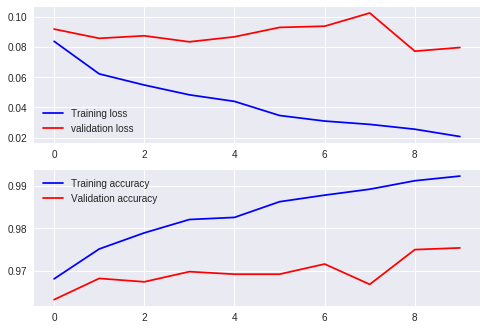

In [51]:
# Plot the loss and accuracy curves for training and validation for vgg16
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [52]:
model_final.evaluate_generator(train_generator,steps_per_epoch)

[0.010504658358840971, 0.9966000032424926]

In [53]:
model_final.evaluate_generator(validation_generator,validation_steps)

[0.08701409613713622, 0.9728000104427338]